In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device_u = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_v = torch.device('cuda:1' if torch.cuda.device_count() > 1 else device_u)
device_p = torch.device('cuda:2' if torch.cuda.device_count() > 2 else device_u)
device_T = torch.device('cuda:3' if torch.cuda.device_count() > 3 else device_u)

print(f"device_u: {device_u}")
print(f"device_v: {device_v}")
print(f"device_p: {device_p}")
print(f"device_T:{device_T}")

device_u: cuda:0
device_v: cuda:1
device_p: cuda:2
device_T:cuda:3


In [5]:
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers = 4, neurons = 100):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)
    
net_u = FCN(in_dim = 2, out_dim = 1).to(device_u)
net_v = FCN(in_dim = 2, out_dim = 1).to(device_v)
net_p = FCN(in_dim = 2, out_dim = 1).to(device_p)
net_T = FCN(in_dim = 2, out_dim = 1).to(device_T)

In [6]:
def generate_collocation_points(N):
    x = torch.rand(N,1)
    y = torch.rand(N,1)

    X = torch.cat([x,y], dim = 1)
    return X

N_f = 10000

X_f = generate_collocation_points(N_f)

X_f_u = X_f.clone().detach().to(device_u).requires_grad_(True)
X_f_v = X_f.clone().detach().to(device_v).requires_grad_(True)
X_f_p = X_f.clone().detach().to(device_p).requires_grad_(True)
X_f_T = X_f.clone().detach().to(device_T).requires_grad_(True)


In [7]:
def generate_boundary_points(N):
    x_l = torch.zeros(N,1) ; x_r = torch.ones(N,1); ylr = torch.rand(N,1)
    b_l = torch.cat([x_l,ylr], dim = 1); b_r = torch.cat([x_r,ylr], dim = 1)

    y_b = torch.zeros(N,1); y_t = torch.ones(N,1); xbt = torch.rand(N,1)
    b_b = torch.cat([xbt,y_b], dim = 1); b_t = torch.cat([xbt,y_t], dim = 1)

    b = torch.cat([b_l,b_r,b_b,b_t], dim = 0)

    return b

N_b = 2000

X_b = generate_boundary_points(N_b)
X_b_u = X_b.clone().detach().to(device_u)
X_b_v = X_b.clone().detach().to(device_v)
X_b_T = X_b.clone().detach().to(device_T)

In [8]:
X_p = torch.tensor([[0.0,0.0]],dtype=torch.float32).to(device_p)



In [9]:
def compute_residual_u():
    # Evaluate u and its derivatives on device_u
    u = net_u(X_f_u)
    grads_u = autograd.grad(u, X_f_u, grad_outputs=torch.ones_like(u),create_graph= True )[0]

    u_x = grads_u[:,0:1]
    u_y = grads_u[:,1:2]

    u_x_x = autograd.grad(u_x, X_f_u, grad_outputs=torch.ones_like(u_x),create_graph= True )[0][:,0:1]
    u_y_y = autograd.grad(u_y, X_f_u, grad_outputs=torch.ones_like(u_y),create_graph= True )[0][:,1:2]

    # Get v and p as constants on device_u
    v = net_v(X_f_v).detach().to(device_u)
    p = net_p(X_f_p)

    # Spatial derivatives of pressure
    p_x = autograd.grad(p, X_f_p, grad_outputs=torch.ones_like(p),create_graph= True,allow_unused= True )[0][:,0:1].to(device_u)

    nu = 1.00/400

    res_u = u * u_x + v * u_y + p_x - nu * (u_x_x + u_y_y)

    return res_u


In [10]:
def compute_residual_v():
    # Evaluate v and its derivatives on device_v
    v = net_v(X_f_v)
    grads_v = autograd.grad(v, X_f_v, grad_outputs=torch.ones_like(v),create_graph= True )[0]

    v_x = grads_v[:,0:1]
    v_y = grads_v[:,1:2]

    v_x_x = autograd.grad(v_x, X_f_v, grad_outputs=torch.ones_like(v_x),create_graph= True )[0][:,0:1]
    v_y_y = autograd.grad(v_y, X_f_v, grad_outputs=torch.ones_like(v_y),create_graph= True )[0][:,1:2]

    # Get u and p as constants on device_v
    u = net_u(X_f_u).detach().to(device_v)
    p = net_p(X_f_p)

    # Spatial derivatives of pressure
    p_y = autograd.grad(p, X_f_p, grad_outputs=torch.ones_like(p),create_graph= True,allow_unused= True )[0][:,1:2].to(device_v)

    nu = 1.00/400

    res_v = u * v_x + v * v_y + p_y - nu * (v_x_x + v_y_y)

    return res_v

In [11]:
def compute_residual_continuity():
    # Divergence of velocity field on GPU 0
    u = net_u(X_f_u)
    v = net_v(X_f_v)
    u_x = autograd.grad(u, X_f_u, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_y = autograd.grad(v, X_f_v, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1:2]
    res_c = u_x + v_y.to(device_u)
    return res_c

In [12]:
def compute_residual_T():
    # Evaluate T and its derivatives on device_T
    T = net_T(X_f_T)
    grads_T = autograd.grad(T,X_f_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]

    T_x = grads_T[:,0:1]
    T_y = grads_T[:,1:2]

    T_x_x = autograd.grad(T_x,X_f_T,grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:,0:1]
    T_y_y = autograd.grad(T_y,X_f_T,grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:,1:2]

    # Get u,v as constants on device_T
    u = net_u(X_f_u).detach().to(device_T)
    v = net_v(X_f_v).detach().to(device_T)

    alpha = 0.01

    res_T = u * T_x + v * T_y - alpha * (T_x_x + T_y_y)
    
    return res_T





In [13]:
def boundary_loss():
    boundary_u = net_u(X_b_u)
    boundary_v = net_v(X_b_v)
    boundary_T = net_T(X_b_T)

    lid_points = (X_b[:,1] == 1).unsqueeze(1)

    wall_points = (X_b[:,1] != 1).unsqueeze(1)

    # Boundary conditions on walls, excluding the lid: u = v = 0, T = 0

    loss_wall = torch.mean((boundary_u[wall_points]) ** 2) + torch.mean((boundary_v[wall_points]) ** 2).to(device_u) + torch.mean((boundary_T[wall_points]) ** 2).to(device_u)

    # Boundary conditions on lid. u = 1, v = 0, T = 1

    loss_lid = torch.mean((boundary_u[lid_points] - 1.00) ** 2) + torch.mean((boundary_v[lid_points]) ** 2).to(device_u) + torch.mean((boundary_T[lid_points] - 1.00) ** 2).to(device_u)

    p_pred = net_p(X_p)
    loss_p = torch.mean((p_pred) ** 2).to(device_u)

    return loss_wall, loss_lid, loss_p


In [14]:
def compute_losses():
    # Compute individual residuals
    res_u = compute_residual_u()
    res_v = compute_residual_v()
    res_c = compute_residual_continuity()
    res_T = compute_residual_T()
    # Aggregate into per-network losses (MSE) and return
    loss_u = torch.mean(res_u**2) + torch.mean(res_c**2)
    loss_v = torch.mean(res_v**2)
    loss_T = torch.mean(res_T**2)

    loss_wall, loss_lid, loss_p = boundary_loss()

    loss_int = loss_u + loss_v.to(device_u) + loss_T.to(device_u)
    loss_bc = loss_wall + loss_lid
    loss_p = loss_p

    total_loss = loss_int + loss_bc + loss_p

    return loss_u, loss_v, loss_T, loss_bc, loss_p, total_loss

    
    

In [15]:
optimizer_u = torch.optim.Adam(net_u.parameters(), lr = 1e-3)
optimizer_v = torch.optim.Adam(net_v.parameters(), lr = 1e-3)
optimizer_p = torch.optim.Adam(net_p.parameters(), lr = 1e-3)
optimizer_T = torch.optim.Adam(net_T.parameters(), lr = 1e-3)

In [16]:
num_epochs = 10000

loss_u_list, loss_v_list, loss_T_list, loss_bc_list, loss_p_list, total_loss_list = [],[],[],[],[],[]

for epoch in range(num_epochs):
    optimizer_u.zero_grad()
    optimizer_v.zero_grad()
    optimizer_p.zero_grad()
    optimizer_T.zero_grad()

    loss_u, loss_v, loss_T, loss_bc, loss_p, total_loss = compute_losses()

    loss_u.backward(retain_graph=True)
    loss_v.backward(retain_graph=True)
    loss_T.backward(retain_graph=True)
    loss_bc.backward(retain_graph=True)
    loss_p.backward()

    optimizer_u.step()
    optimizer_v.step()
    optimizer_p.step()
    optimizer_T.step()

    loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item()); loss_T_list.append(loss_T.item())
    loss_bc_list.append(loss_bc.item()); loss_p_list.append(loss_p.item())
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_T={loss_T.item():.3e}, loss_bc={loss_bc.item():.3e}, loss_p={loss_p.item():.3e} total={total_loss.item():.3e}")

    
    

/home/soumik/miniconda3/envs/pyro_env/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: loss_u=1.881e-03, loss_v=1.294e-03, loss_T=6.156e-06, loss_bc=1.631e+00, loss_p=1.228e-03 total=1.636e+00
Epoch 500: loss_u=4.034e-03, loss_v=6.894e-04, loss_T=1.078e-02, loss_bc=4.973e-02, loss_p=3.512e-06 total=6.524e-02
Epoch 1000: loss_u=3.425e-03, loss_v=7.323e-04, loss_T=8.731e-03, loss_bc=4.834e-02, loss_p=9.831e-07 total=6.123e-02
Epoch 1500: loss_u=3.290e-03, loss_v=7.219e-04, loss_T=8.862e-03, loss_bc=4.357e-02, loss_p=3.341e-09 total=5.645e-02
Epoch 2000: loss_u=3.953e-03, loss_v=7.279e-04, loss_T=5.177e-03, loss_bc=3.550e-02, loss_p=1.196e-05 total=4.537e-02
Epoch 2500: loss_u=3.037e-03, loss_v=7.337e-04, loss_T=2.209e-03, loss_bc=4.397e-02, loss_p=3.507e-05 total=4.999e-02
Epoch 3000: loss_u=2.964e-03, loss_v=7.095e-04, loss_T=1.571e-03, loss_bc=2.812e-02, loss_p=1.628e-06 total=3.337e-02
Epoch 3500: loss_u=3.514e-03, loss_v=8.445e-04, loss_T=2.071e-03, loss_bc=2.367e-02, loss_p=7.458e-06 total=3.011e-02
Epoch 4000: loss_u=6.708e-03, loss_v=5.927e-04, loss_T=2.107

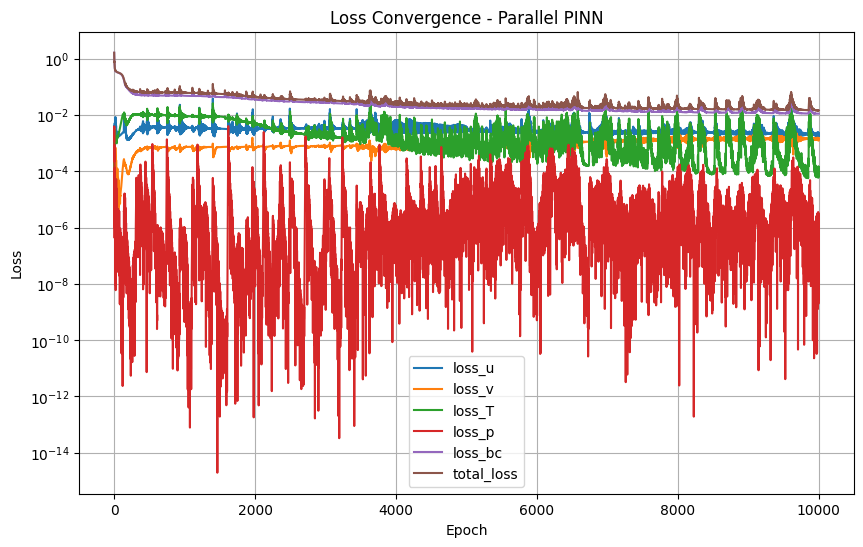

In [17]:
plt.figure(figsize=(10,6))
plt.plot(loss_u_list, label='loss_u')
plt.plot(loss_v_list, label='loss_v')
plt.plot(loss_T_list, label='loss_T')
plt.plot(loss_p_list, label='loss_p')
plt.plot(loss_bc_list, label='loss_bc')
plt.plot(total_loss_list, label='total_loss')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Convergence - Parallel PINN'); plt.legend(); plt.grid(True)
plt.show()

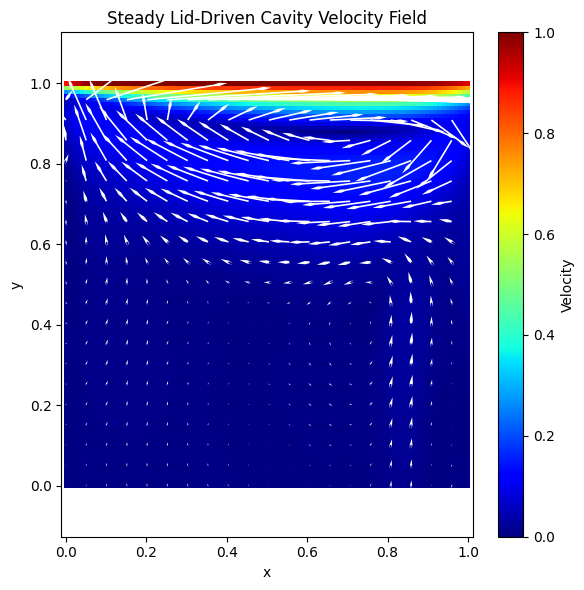

In [18]:
# Visualization

x = np.linspace(0,1,100)   # 100 X 1
y = np.linspace(0,1,100)   # 100 X 1

X,Y = np.meshgrid(x,y)     # Both 100 X 100

XY = np.stack([X.ravel(),Y.ravel()], axis = 1)   # 10000 X 2

net_u.eval()
net_v.eval()

with torch.no_grad():
    inp_u = torch.tensor(XY, dtype = torch.float32, device = device_u)
    inp_v = torch.tensor(XY, dtype = torch.float32, device = device_v)
    
    u_pred = net_u(inp_u).cpu().numpy()    # 10000 X 1
    v_pred = net_v(inp_v).cpu().numpy()    # 10000 X 1

U = u_pred.reshape(100,100)  # 100 X 100
V = v_pred.reshape(100,100)  # 100 X 100

speed = np.sqrt(U**2 + V**2)


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,speed, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Velocity')

dx = slice(None, None, 5)
dy = slice(None, None, 5)

plt.quiver(X[dx,dy], Y[dx,dy], U[dx,dy], V[dx,dy], color='white', scale_units='xy', scale=1,
    width=0.004, headwidth=2, headlength=5, headaxislength=8, minlength=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Steady Lid-Driven Cavity Velocity Field')
plt.axis('equal')
plt.tight_layout()
plt.show()


